In [1]:
import gc
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing
from datagenerators import DataGeneratorBars
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [3]:
max_neutrons = 4
config = {
    "distance": 15,
    "doubleplane": 30,
    "energy": 600,
    "erel": 500,
    "neutrons": range(1, max_neutrons + 1),
    "subruns": range(6),  # range(19),
    "subrun_cache_size": 6,
    "batch_size": 100,
    "label": "nPN",
    "mode": "bars",
}

validation_config = config.copy()
validation_config["subruns"] = [19]

In [4]:
start = time.time()
generator = DataGeneratorBars(config)
validation_generator = DataGeneratorBars(validation_config)
print(time.time() - start)

Rows in one file: 10000
400 batches per subrun
2400 total batches in [range(0, 6)] caches
Loading subruns range(0, 6) for cache 0
Rows in one file: 10000
400 batches per subrun
400 total batches in [[19]] caches
Loading subruns [19] for cache 0
216.5406403541565


In [5]:
models = defaultdict(keras.models.Sequential)

models["(SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(10, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(20, SM)"].add(keras.layers.Dense(units=20, activation="relu"))
models["(20, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(100, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(100, 10, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

models["(3000, 50, SM)"].add(keras.layers.Dense(units=3000, activation="relu"))
models["(3000, 50, SM)"].add(keras.layers.Dense(units=50, activation="relu"))
models["(3000, 50, SM)"].add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

optimizer = keras.optimizers.Adam
loss = keras.losses.CategoricalCrossentropy

histories = {}
for name, model in models.items():
    print(name)
    model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
    histories[name] = model.fit(generator, verbose=2, epochs=20, shuffle=False, validation_data=validation_generator)
    print("----")

(SM)
Epoch 1/20
2400/2400 - 31s - loss: 1.3112 - accuracy: 0.4829 - val_loss: 1.1737 - val_accuracy: 0.5583
Epoch 2/20
2400/2400 - 17s - loss: 1.1111 - accuracy: 0.5745 - val_loss: 1.0651 - val_accuracy: 0.5831
Epoch 3/20
2400/2400 - 16s - loss: 1.0300 - accuracy: 0.5940 - val_loss: 1.0050 - val_accuracy: 0.5965
Epoch 4/20
2400/2400 - 16s - loss: 0.9799 - accuracy: 0.6039 - val_loss: 0.9651 - val_accuracy: 0.6031
Epoch 5/20
2400/2400 - 15s - loss: 0.9456 - accuracy: 0.6103 - val_loss: 0.9372 - val_accuracy: 0.6068
Epoch 6/20
2400/2400 - 15s - loss: 0.9208 - accuracy: 0.6148 - val_loss: 0.9168 - val_accuracy: 0.6095
Epoch 7/20
2400/2400 - 15s - loss: 0.9021 - accuracy: 0.6180 - val_loss: 0.9011 - val_accuracy: 0.6113
Epoch 8/20
2400/2400 - 17s - loss: 0.8874 - accuracy: 0.6206 - val_loss: 0.8887 - val_accuracy: 0.6138
Epoch 9/20
2400/2400 - 17s - loss: 0.8755 - accuracy: 0.6231 - val_loss: 0.8786 - val_accuracy: 0.6154
Epoch 10/20
2400/2400 - 16s - loss: 0.8657 - accuracy: 0.6251 - val_

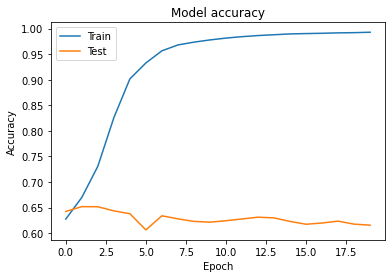

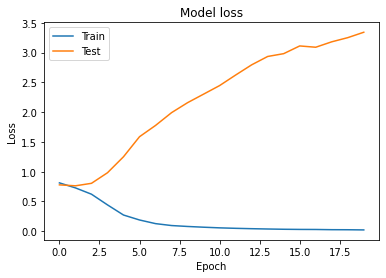

In [13]:
history = histories["(3000, 50, SM)"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [ ]:
del generator
del validation_generator
gc.collect();

In [8]:
test_config = config.copy()
test_config["subruns"] = range(14, 17)
test_generator = DataGeneratorBars(test_config)

Rows in one file: 10000
400 batches per subrun
1200 total batches in [range(14, 17)] caches
Loading subruns range(14, 17) for cache 0


In [9]:
X = test_generator.features
y_true = np.argmax(test_generator.labels, axis=1)

In [16]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

for name, model in models.items():
    gc.collect()
    y_pred = np.argmax(model.predict(X), axis=1)
    print(name)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(bac)
    cm = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1))
    print(cm)
    cmrel = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1), normalize="true")
    print((cmrel * 100).round())

(SM)
0.5053020844226894
[[    0  1544     0     0     0]
 [    0 24213  4280    22     9]
 [    0  6711 15701  7161   362]
 [    0  1106  6693 12964  9234]
 [    0   153  1748  6470 21629]]
[[  0. 100.   0.   0.   0.]
 [  0.  85.  15.   0.   0.]
 [  0.  22.  52.  24.   1.]
 [  0.   4.  22.  43.  31.]
 [  0.   1.   6.  22.  72.]]
(10, SM)
0.712890064554213
[[ 1544     0     0     0     0]
 [  254 24767  3474    13    16]
 [   36  6913 17849  4853   284]
 [    2  1232  8334 11621  8808]
 [    1   179  2304  6141 21375]]
[[100.   0.   0.   0.   0.]
 [  1.  87.  12.   0.   0.]
 [  0.  23.  60.  16.   1.]
 [  0.   4.  28.  39.  29.]
 [  0.   1.   8.  20.  71.]]
(20, SM)
0.7112325439392755
[[ 1544     0     0     0     0]
 [  290 24578  3631     9    16]
 [   39  6772 17916  4840   368]
 [    3  1180  8433 11685  8696]
 [    1   166  2351  6288 21194]]
[[100.   0.   0.   0.   0.]
 [  1.  86.  13.   0.   0.]
 [  0.  23.  60.  16.   1.]
 [  0.   4.  28.  39.  29.]
 [  0.   1.   8.  21.  71.]]
